**MUSIC CLASSIFICATION**

This project will seek to train models that predicts the genre of music.

The GTZAN genre classification datasets was used to obtain audio samples with similar size and frequency range.
- 1000 audio samples
- 30 seconds each

Dataset: http://marsyas.info/downloads/datasets.html

**10 Music Genres:**
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock

**Models**
- Start with K-nearest neighbour
- Conv Neural Network


NOTE:
This notebook's content is mainly taken from https://data-flair.training/blogs/python-project-music-genre-classification/ and serves more as a starting point for this project!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math, random, pickle, os, operator
from tempfile import TemporaryFile

from scipy.io import wavfile
from python_speech_features import mfcc
%matplotlib inline

**Feature Extraction**

MFCC (Mel Frequency Cepstral Coefficients):
- cepstrum reprsents information on the rate of change in spectral bands
    - spectrum of the log of frequency spectrum of time signal
- relates perceived frequency of tone to actual measured frequency
    - scales frequency to match what a human hears (can identify small changes at lower frequencies)
- MFCC gives representation of phonemes being produced through shape of vocal tract
- Algorithm:
    1. divide signals into smaller frames (20-40ms) as samples they constantly change
    2. Identify frequencies in each frame
    3. Use Mel filterbank to find sum of energy in different frequency bands
    4. Take log (as perceived volume scales logarithmically)
    5. Compute Discrete Cosing Transform (DCT)
        - filterbanks overlapping, so energies are correlated - DCT "decorrelates energies", so diagonal covariance matrices can be used to model features
    6. can keep only lower 12 DCT coefficinets as higher DCT coefficients represent fast changes in filterbank energies - can worsen performance?
    
    
http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


In [7]:
# feature extraction
path  = "D:/Datasets/genres/"
f = open("feat.dat",'wb')

genre=0
for fold in os.listdir(path):
    genre+=1
    if genre==11:
        break
    for file in os.listdir(path+fold):
        (rate, sig) = wavfile.read(path+fold+"/"+file) # returns sample rate and data (sig)
        mfcc_feat = mfcc(sig, rate, winlen=0.02, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0) # mean along column
        feature = (mean_matrix, covariance, genre)
        pickle.dump(feature, f)

f.close()

In [16]:
# loading data - could try converting ot pandas Dataframe instead
dataset = []
train = []
test = []
with open("feat.dat", 'rb') as f:
    while True:
        try:
            dataset.append(pickle.load(f))
        except EOFError:
            f.close()
            break
    
    for x in range(len(dataset)):
        if random.random() < 0.66:
            train.append(dataset[x])
        else:
            test.append(dataset[x])

In [18]:
len(test)

333

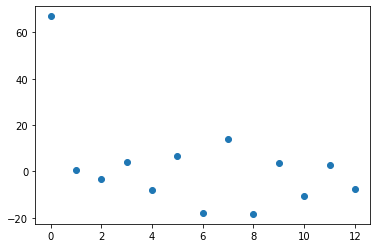

In [5]:
x = range(len(m))
plt.scatter(x, m)

<AxesSubplot:>

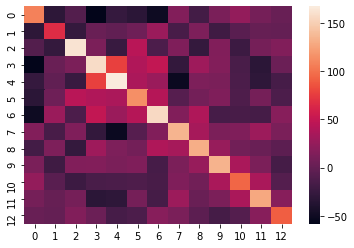

In [6]:
sns.heatmap(c)

**Implementing KNN Model**

In [30]:
# get distance between examples
def distance (inst1, inst2, k):
    distance = 0
    mm1 = inst1[0]
    cm1 = inst1[1]
    mm2 = inst2[0]
    cm2 = inst2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) # 
    distance += np.dot(np.dot((mm2-mm1).transpose(), np.linalg.inv(cm2)), mm2-mm1)
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance
    

# get distance between feature vector and find neighbors
def getNeighbours(trainingSet, instance, k):
    distances = []
    for x in range (len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist)) # distance with label
    distances.sort(key=operator.itemgetter(1)) # sort by distance (index 1 in tuple)
    neighbours = []
    for x in range(k): 
        neighbours.append(distances[x][0]) 
    return neighbours # nearest k instances

def nearestClass(neighbours):
    classVote = {}
    for x in range(len(neighbours)):
        response = neighbours[x] # distance
        if response in classVote:
            classVote[response]+=1
        else:
            classVote[response]=1
    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]

# model evaluation
def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct+=1
    return 1.0*correct/len(testSet) # fraction correct
        
        
        

In [37]:
# make prediction and get accuracies for K values from 1-8
accuracies = []
for k in range(1,9):
    predictions = []
    for x in range(len(test)):
        predictions.append(nearestClass(getNeighbours(train, test[x], k)))

    accuracy = getAccuracy(test, predictions)
    accuracies.append(accuracy)
    print(accuracy)

0.6336336336336337
0.6336336336336337
0.6516516516516516
0.6816816816816816
0.6876876876876877
0.6906906906906907
0.6906906906906907
0.6846846846846847


Model evaluation

- K nearest neighbour model accuracywith K=5 gets an accuracy of 0.688

<table>
    <tr>
        <th>K value</th>
        <th>Accuracy</th>
    </tr>
    <tr><td>1</td><td>0.6336</td></tr>
    <tr><td>2</td><td>0.6336</td></tr>
    <tr><td>3</td><td>0.6517</td></tr>
    <tr><td>4</td><td>0.6817</td></tr>
    <tr><td>5</td><td>0.6877</td></tr>
    <tr><td>6</td><td>0.6907</td></tr>
    <tr><td>7</td><td>0.6907</td></tr>
    <tr><td>8</td><td>0.6847</td></tr>
</table>

Accuracy seems to peak at around K=6 or 7 and then falls

<AxesSubplot:xlabel='K', ylabel='Accuracy'>

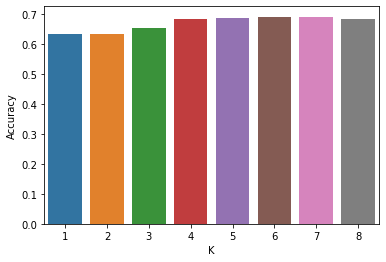

In [53]:
# plot of accuracies
acc = pd.DataFrame(accuracies)
acc.columns = ["Accuracy"]
acc["K"] = list(range(1,9))

sns.barplot(x="K", y="Accuracy", data=acc)

In [51]:
acc.columns = ["Accuracy"]
acc["K"] = list(range(1,9))

In [52]:
acc

,Accuracy,K
0,0.633634,1
1,0.633634,2
2,0.651652,3
3,0.681682,4
4,0.687688,5
5,0.690691,6
6,0.690691,7
7,0.684685,8
